In [27]:
#!pip install contractions
# Para google collab, comentar si no se usa

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import re
import os

def clean_invalid_xml_chars(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    def clean_body_content(match):
        body_text = match.group(1)
        cleaned_text = re.sub(r'[<>&"\']', '', body_text)  # Elimina caracteres problemáticos
        return f"<BODY>{cleaned_text}</BODY>"

    content = re.sub(r'<BODY>(.*?)</BODY>', clean_body_content, content, flags=re.DOTALL | re.IGNORECASE)
    return content

def parse_chatlog(xml_file):
    try:
        content = clean_invalid_xml_chars(xml_file)
        root = ET.fromstring(content)

        predator_usernames = [sn.findtext('USERNAME') for sn in root.findall('PREDATOR/SCREENNAME')]
        victim_usernames = [sn.findtext('USERNAME') for sn in root.findall('VICTIM/SCREENNAME')]

        posts = []
        for post in root.findall('POST'):
            username = post.findtext("USERNAME")
            if not username or username.strip() == "":
                continue  # ⛔️ Saltar líneas sin username

            role = (
                'predator' if username in predator_usernames
                else 'victim' if username in victim_usernames
                else 'desconocido'
            )

            post_data = {
                'username': username.strip(),
                'datetime': post.findtext("DATETIME"),
                'body'    : post.findtext('BODY'),
                'role'    : role
            }

            posts.append(post_data)

        return pd.DataFrame(posts)

    except ET.ParseError as e:
        raise ET.ParseError(f"{xml_file} → {str(e)}")


# Revisar errores en los archivos xml

def revisar_errores_en_xmls(folder_path):
    errores = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            full_path = os.path.join(folder_path, filename)
            try:
                _ = parse_chatlog(full_path)
            except ET.ParseError as e:
                errores.append(str(e))

    if errores:
        print("\n❌ Archivos con errores de parseo:\n")
        for err in errores:
            print(f"  - {err}")
    else:
        print("✅ Todos los archivos XML fueron procesados sin errores.")

revisar_errores_en_xmls("GeneralData")


✅ Todos los archivos XML fueron procesados sin errores.


In [ ]:
#Creamos el DataFrame
df = parse_chatlog("GeneralData/asian_kreationz.xml")
df

,username,datetime,body,role
0,asian_kreationz,(3:56:13 pm),hi,predator
1,torn_angel_2005,(3:57:10 pm),hey,victim
2,asian_kreationz,(3:57:20 pm),hello,predator
3,asian_kreationz,(3:57:30 pm),howu doin,predator
4,asian_kreationz,(3:57:36 pm),asl?,predator
...,...,...,...,...
968,torn_angel_2005,(10:27:53 pm),310-923-8191 ?,victim
969,torn_angel_2005,(10:27:56 pm),ok,victim
970,asian_kreationz,(10:28:00 pm),yup,predator
971,torn_angel_2005,(10:28:01 pm),cya!,victim


In [ ]:
# Ruta de tu carpeta con los XMLs
folder_path = "GeneralData"
all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        full_path = os.path.join(folder_path, filename)
        df = parse_chatlog(full_path)
        if not df.empty:
            df['file'] = filename  # Para saber de qué archivo viene cada línea
            all_dfs.append(df)

# Combinar todos los DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)
print(combined_df.head())


           username                datetime  \
0        steelmanoo  (09/24/08 10:13:40 pm)   
1  14 year old girl  (09/24/08 10:14:23 pm)   
2        steelmanoo  (09/24/08 10:14:40 pm)   
3        steelmanoo  (09/24/08 10:15:06 pm)   
4  14 year old girl  (09/24/08 10:15:13 pm)   

                                       body      role            file  
0  hello carriebare and what are you up to?  predator  steelmanoo.xml  
1                                        hi    victim  steelmanoo.xml  
2                                        hi  predator  steelmanoo.xml  
3          what are you looking for tonight  predator  steelmanoo.xml  
4                              just chattin    victim  steelmanoo.xml  


In [ ]:
combined_df.head()

,username,datetime,body,role,file
0,steelmanoo,(09/24/08 10:13:40 pm),hello carriebare and what are you up to?,predator,steelmanoo.xml
1,14 year old girl,(09/24/08 10:14:23 pm),hi,victim,steelmanoo.xml
2,steelmanoo,(09/24/08 10:14:40 pm),hi,predator,steelmanoo.xml
3,steelmanoo,(09/24/08 10:15:06 pm),what are you looking for tonight,predator,steelmanoo.xml
4,14 year old girl,(09/24/08 10:15:13 pm),just chattin,victim,steelmanoo.xml


In [ ]:
combined_df.tail()

,username,datetime,body,role,file
65194,manofdarkneedsl951,(10:27:51 pm),maybe not,predator,manofdarkneedsl951.xml
65195,rachel_west90,(10:28:06 pm),and your profile,victim,manofdarkneedsl951.xml
65196,manofdarkneedsl951,(10:28:18 pm),nope,predator,manofdarkneedsl951.xml
65197,rachel_west90,(10:28:31 pm),why not?,victim,manofdarkneedsl951.xml
65198,rachel_west90,(10:29:40 pm),u there?,victim,manofdarkneedsl951.xml


In [ ]:
import re
import contractions

replacement_dict = {
    r"\bluv\b": "love",
    r"\bdoin\b": "doing",
    r"\bu\b": "you",
    r"\bru\b": "are you",
    r"\br u\b": "are you",
    r"\bya\b": "you",
    r"\byr\b": "your",
    r"\bur\b": "your",
    r"\br\b": "are",
    r"\bim\b": "i'm",
    r"\bidk\b": "i don't know",
    r"\bc\b": "see",
    r"\bc u\b": "see you",
    r"\bcya\b": "see you",
    r"\bbtw\b": "by the way",
    r"\bomg\b": "oh my god",
    r"\bthx\b": "thanks",
    r"\bpls\b": "please",
    r"\bplz\b": "please",
    r"\blol\b": "laughing out loud",
    r"\blmao\b": "laughing my ass off",
    r"\bwtf\b": "what the fuck",
    r"\bwth\b": "what the hell",
    r"\bomw\b": "on my way",
    r"\bl8r\b": "later",
    r"\bgr8\b": "great",
    r"\bmsg\b": "message",
    r"\btxt\b": "text",
    r"\bpic\b": "picture",
    r"\bttyl\b": "talk to you later",
    r"\bbrb\b": "be right back",
    r"\bafk\b": "away from keyboard",
    r"\bbf\b": "boyfriend",
    r"\bgf\b": "girlfriend",
    r"\bwanna\b": "want to",
    r"\bgonna\b": "going to",
    r"\bgotta\b": "got to",
    r"\bk\b": "okay",
    r"\bok\b": "okay",
    r"\bcuz\b": "because",
    r"\bcoz\b": "because",
    r"\btho\b": "though",
    r"\btho\b": "though",
    r"\btho\b": "though",
    r"\bdat\b": "that",
    r"\bda\b": "the",
    r"\bdis\b": "this",
    r"\bdem\b": "them",
    r"\bain't\b": "is not",
    r"\bgotcha\b": "got you",
    r"\bsorta\b": "sort of",
    r"\bkinda\b": "kind of",
    r"\bdunno\b": "don't know",
    r"\btryna\b": "trying to",
    r"\blemme\b": "let me",
    r"\bgimme\b": "give me",
    r"\bwhatcha\b": "what are you",
    r"\bill\b": "i will",
    r"\b2\b": "too",
    r"\b4\b": "for",
    r"\bme2\b": "me too",
    r"\bp\b": "",
    r"\bk\b": "ok",
    r"\bgetin\b": "getting",
    r"\bgtg\b": "got to go",
    r"\bu2\b": "you too",
    r"\b2day\b": "today",
    r"\bb4\b": "before",
    r"\b4u\b": "for you",
    r"\b2nite\b": "tonight",
    r"\b2moro\b": "tomorrow",
    r"\b4u\b": "for you",
    r"\b4ever\b": "forever",
    r"\bb4\b": "before",
    r"\b4get\b": "forget",
    r"\bgr8\b": "great",
    r"\b8\b": "ate",
    r"\b1\b": "one",
    r"\b1der\b": "wonder",
    r"\b1st\b": "first",
    r"\bcu\b": "see you",
    r"\bc u\b": "see you",
    r"\b4u\b": "for you",
    r"\bu\b": "you",
    r"\bur\b": "your",
    r"\br\b": "are",
    r"\bpls\b": "please",
    r"\bplz\b": "please",
    r"\bthx\b": "thanks",
    r"\bomg\b": "oh my god",
    r"\bcauz\b": "because",
    r"\bcuz\b": "because",
    r"\bhehe\b": "",
    r"\bcomdom\b": "condom",
    r"\bpreggerz\b": "pregnant",
    r"\bmin\b": "minutes",
    r"\bscard\b": "scared",
    r"\bhafta\b": "have to",
    r"\bprof\b": "profile",
    r"\bpromis\b": "promise",
    r"\bcallin\b": "calling",
    r"\bhav\b": "have",
    r"\bno\b": "no",
    r"\bhehe\b": "",
    r"\bsooo\b": "so",
    r"\byeah\b": "yes",
    r"\bwait\b": "wait",

}

def normalize_text(text):
    if not isinstance(text, str):  # Manejo de valores no-string (por si hay NaN)
        return ""

    # Paso 1: Convertir a minúsculas
    text = text.lower()

    # Paso 2: Expandir contracciones con la librería contractions
    text = contractions.fix(text)

    # Paso 3: Reemplazar slangs usando tu diccionario
    for pattern, replacement in replacement_dict.items():
        text = re.sub(pattern, replacement, text)

    # Paso 4: Limpieza adicional (opcional)
    text = re.sub(r'[^a-z0-9\s]', ' ', text) # Elimina caracteres no alfabéticos
    text = re.sub(r'\s+', ' ', text).strip()  # Elimina espacios extras

    return text


In [ ]:
combined_df['normalized_body'] = combined_df['body'].apply(normalize_text)
# Mostrar resultados
combined_df['normalized_body']


,normalized_body
0,hello carriebare and what are you up to
1,hi
2,hi
3,what are you looking for tonight
4,just chattin
...,...
65194,maybe not
65195,and your profile
65196,nope
65197,why not


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


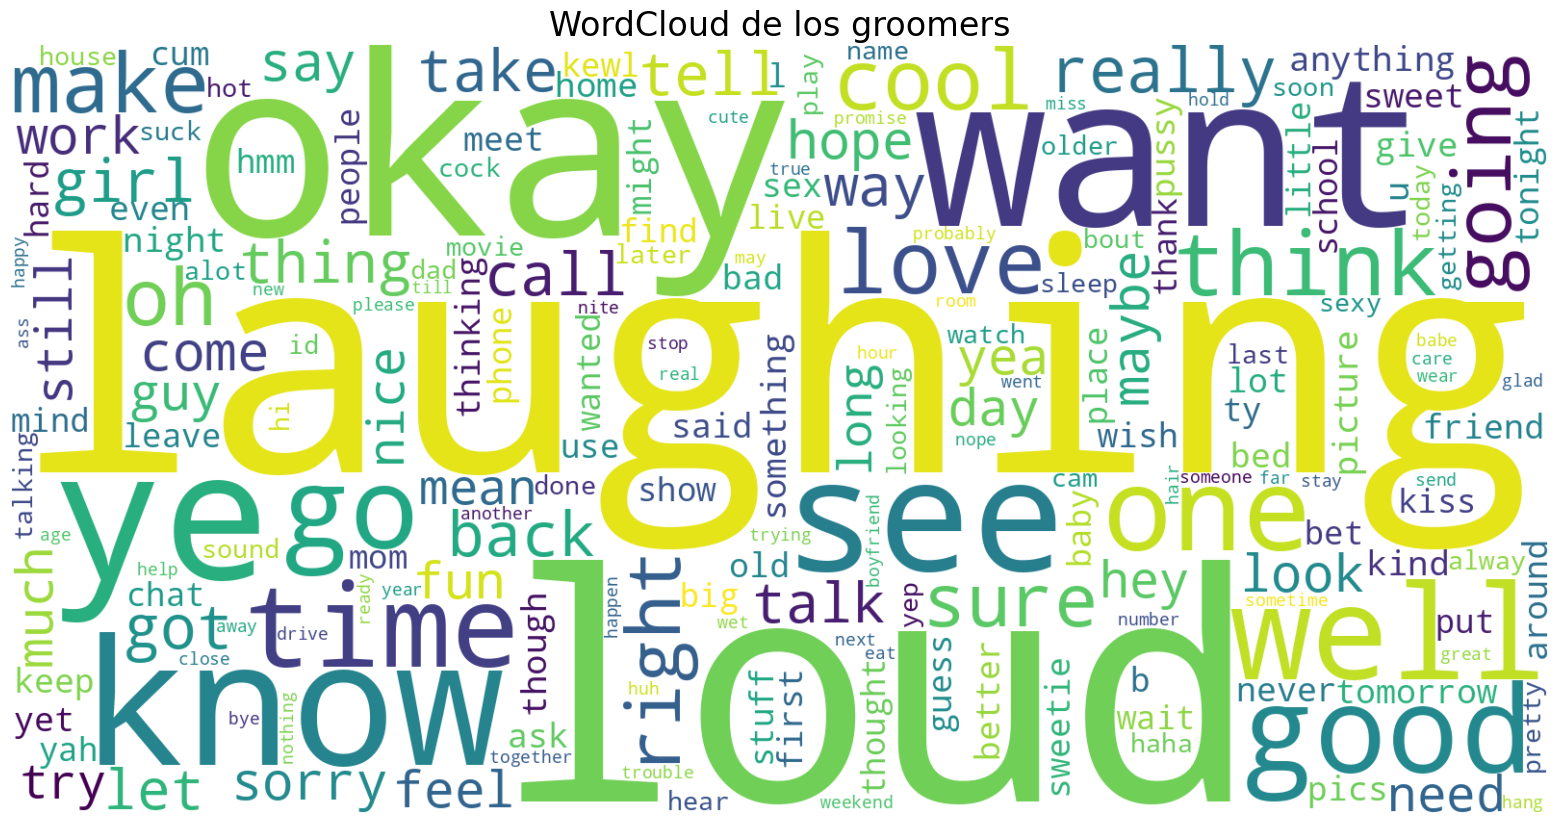

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Une todos los textos del cuerpo de los mensajes en una sola cadena
predator_text = ' '.join(combined_df[combined_df['role'] == 'predator']['normalized_body'].dropna().astype(str))

predator_text = predator_text.lower()

stop_words = set(stopwords.words('english'))

predator_text = re.sub(r'\d+', '', predator_text)
predator_text = re.sub(r'[^\w\s]', '', predator_text)

palabras = [word for word in predator_text.split() if word not in stop_words]

# Crea el objeto WordCloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(' '.join(palabras))

# Mostrar el WordCloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de los groomers", fontsize=24)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


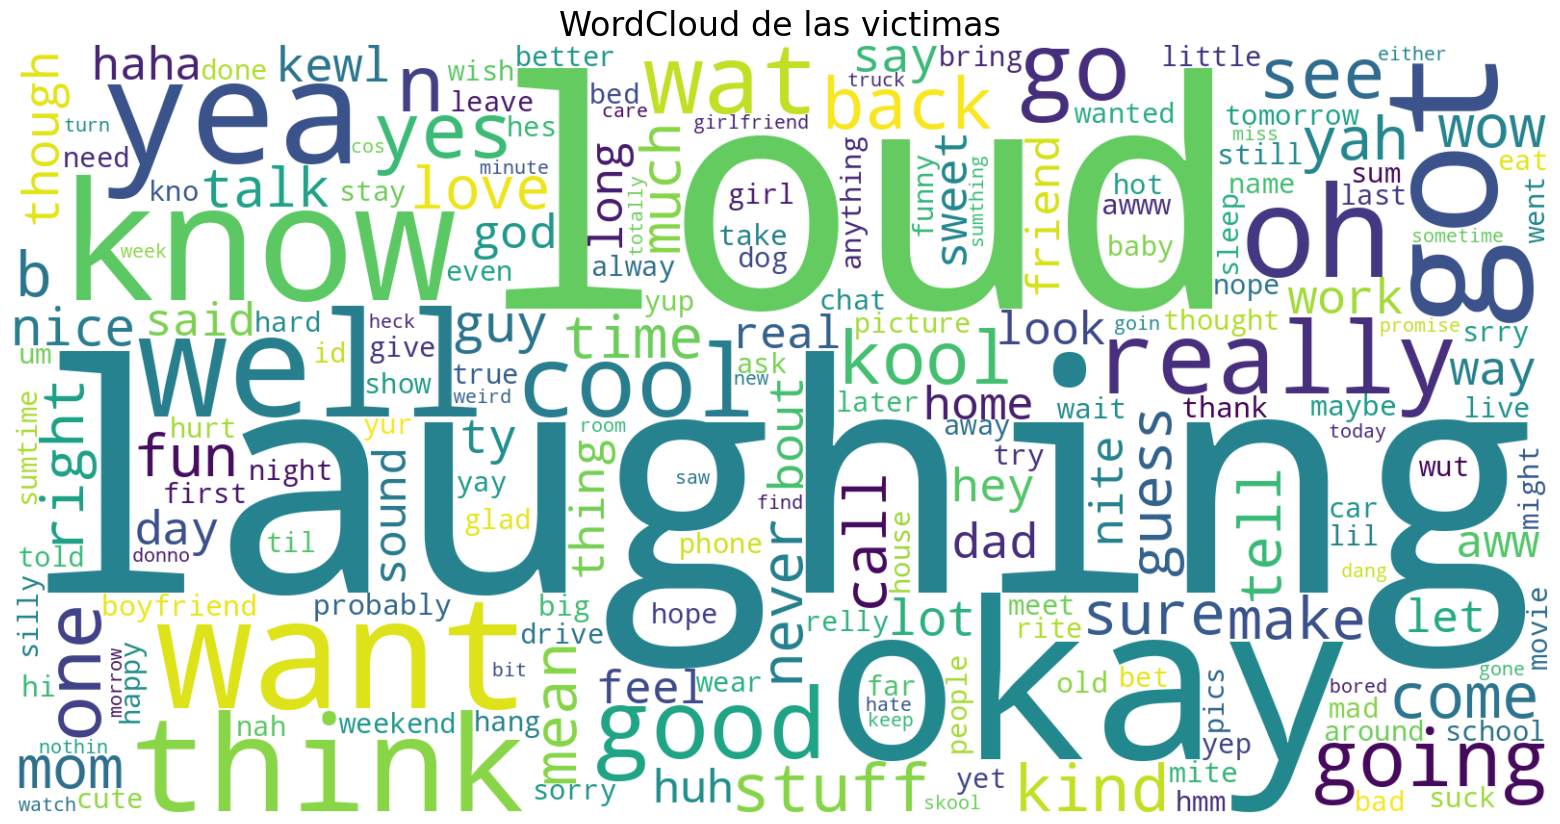

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Une todos los textos del cuerpo de los mensajes en una sola cadena
victim_text = ' '.join(combined_df[combined_df['role'] == 'victim']['normalized_body'].dropna().astype(str))

victim_text = victim_text.lower()

stop_words = set(stopwords.words('english'))

victim_text = re.sub(r'\d+', '', victim_text)
victim_text = re.sub(r'[^\w\s]', '', victim_text)

palabras = [word for word in victim_text.split() if word not in stop_words]

# Crea el objeto WordCloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(' '.join(palabras))

# Mostrar el WordCloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de las victimas", fontsize=24)
plt.show()

Se ha visualizado varios "Slangs" que usan tanto los groomers como las victimas, por lo que se ha creado un diccionario para poder entender mejor las palabras usadas y pasarlas a palabras mas formales

# **Cantidad de mensajes de predadores y victimas en el archivo de ejemplo**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

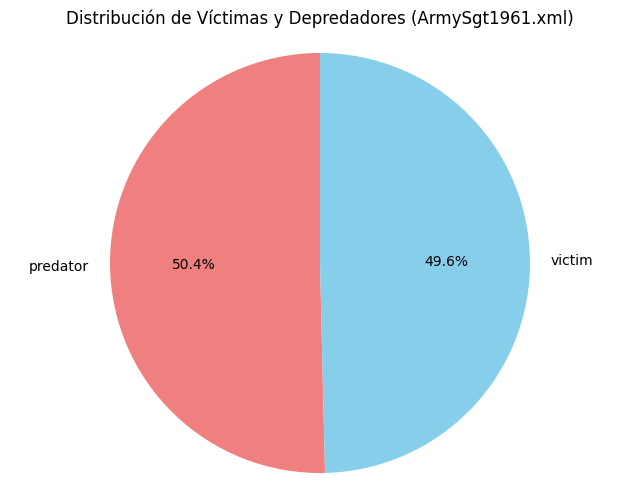

In [ ]:
conteo = combined_df['role'].value_counts()

conteo = conteo[conteo.index.isin(['victim', 'predator'])]

plt.figure(figsize=(8, 6))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
plt.title('Distribución de Víctimas y Depredadores (ArmySgt1961.xml)')
plt.axis('equal')

plt.show()

Contador de la longitud de palabras en archivo *'ArmySgt1961.xml'*

In [ ]:
# Suponiendo que tu DataFrame se llama df
combined_df['word_length'] = combined_df['normalized_body'].str.split().str.len()

# Mostrar las primeras filas para verificar
print(combined_df[['role', 'normalized_body', 'word_length']].head())


       role                          normalized_body  word_length
0  predator  hello carriebare and what are you up to            8
1    victim                                       hi            1
2  predator                                       hi            1
3  predator         what are you looking for tonight            6
4    victim                             just chattin            2


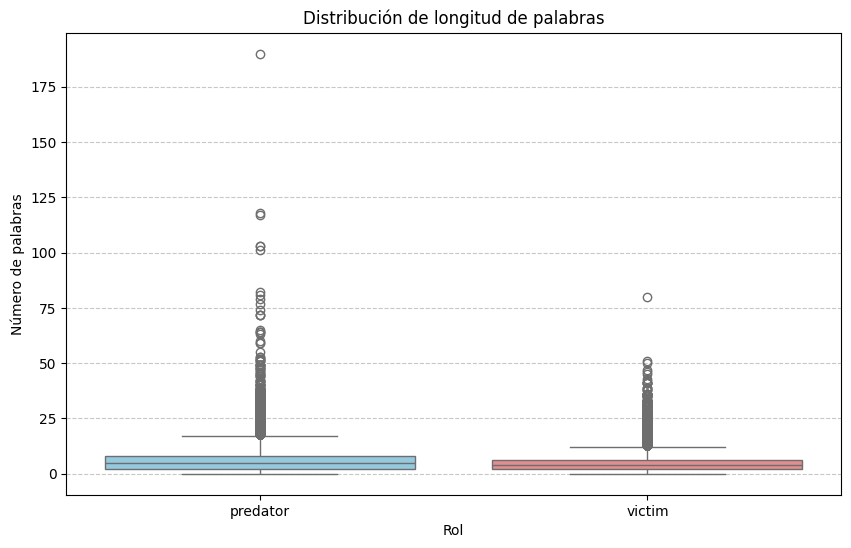

In [ ]:
import seaborn as sns

# Filtrar datos
df_filtered = combined_df[combined_df['role'].isin(['victim', 'predator'])]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='role',
    y='word_length',
    hue='role',  # <- Añadimos hue para evitar el warning
    data=df_filtered,
    palette={'victim': 'lightcoral', 'predator': 'skyblue'},
    legend=False  # <- Ocultamos leyenda si no es necesaria
)
plt.title('Distribución de longitud de palabras')
plt.xlabel('Rol')
plt.ylabel('Número de palabras')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
#plt.ylim(0, 20)   Mostrar solo mensajes con menos de 20 palabras

plt.show()

In [ ]:
pd.set_option('display.max_colwidth', None)  # Desactiva el recorte
print(combined_df[combined_df['role'] == 'predator'].nlargest(1, 'word_length')['normalized_body'])


30712    hi love i have look too see if you came back on a few times i did not like how our talk ended that day i am wondering if i made you upset if i did i am very so sorry i am sorry that one guy hurt you and got you in trouble that one time from our chat that day i was thinking that i sounded like him and i am so so so sorry i totally understand and it hurts me so bad that what happen too you interfer your trust in me fully you are too good of a young women so nice i cannot do that too you i am sorry if i made you feel otherwise i worry about you hunny and i am sad because of this and too let you know i will wait that week of that weekend for that info okay i hope it b toward the beginning of the week i hope you do not think different about me i have something too show you on cam mon night i b on around 10 15 10 30 the regular
Name: normalized_body, dtype: object


In [ ]:

#combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], errors='coerce')
dt_data = combined_df['datetime']

fecha_df = pd.DataFrame({'datetime_str': dt_data})

def preprocess_datetime(dt_str):

    if pd.isna(dt_str) or not isinstance(dt_str, str):
        return None

    #Sacar parentesis
    dt_str = dt_str.strip("()")

    #Sacar corchetes
    dt_str = dt_str.strip("[]")

    # Sacar espacios
    re.sub(r'\s+', ' ', dt_str).strip()

    # Estandarizar am/pm
    dt_str = dt_str.replace('a.m.', 'am').replace('p.m.', 'pm')
    dt_str = dt_str.replace('A.M.', 'AM').replace('P.M.', 'PM')

    if not dt_str:
        return None
    return dt_str

fecha_df['datetime_limpio'] = fecha_df['datetime_str'].apply(preprocess_datetime)
print(fecha_df[['datetime_str', 'datetime_limpio']].head(20))

              datetime_str       datetime_limpio
0   (09/24/08 10:13:40 pm)  09/24/08 10:13:40 pm
1   (09/24/08 10:14:23 pm)  09/24/08 10:14:23 pm
2   (09/24/08 10:14:40 pm)  09/24/08 10:14:40 pm
3   (09/24/08 10:15:06 pm)  09/24/08 10:15:06 pm
4   (09/24/08 10:15:13 pm)  09/24/08 10:15:13 pm
5   (09/24/08 10:15:29 pm)  09/24/08 10:15:29 pm
6   (09/24/08 10:15:38 pm)  09/24/08 10:15:38 pm
7   (09/24/08 10:15:58 pm)  09/24/08 10:15:58 pm
8   (09/24/08 10:16:11 pm)  09/24/08 10:16:11 pm
9   (09/24/08 10:16:35 pm)  09/24/08 10:16:35 pm
10  (09/24/08 10:16:43 pm)  09/24/08 10:16:43 pm
11  (09/24/08 10:17:06 pm)  09/24/08 10:17:06 pm
12  (09/24/08 10:17:16 pm)  09/24/08 10:17:16 pm
13  (09/24/08 10:17:24 pm)  09/24/08 10:17:24 pm
14  (09/24/08 10:17:35 pm)  09/24/08 10:17:35 pm
15  (09/24/08 10:18:01 pm)  09/24/08 10:18:01 pm
16  (09/24/08 10:18:23 pm)  09/24/08 10:18:23 pm
17  (09/24/08 10:18:24 pm)  09/24/08 10:18:24 pm
18  (09/24/08 10:18:49 pm)  09/24/08 10:18:49 pm
19  (09/24/08 10:18:

In [ ]:
# Formato fecha y hora
formats_to_try = [
    "%m/%d/%Y %I:%M:%S %p",  # ej, 5/12/2006 1:53:15 pm
    "%m/%d/%y %I:%M:%S %p",  # ej, 10/01/08 9:43:46 pm
    "%I:%M:%S %p",           # ej, 7:14:04 pm
    "%I:%M %p"
]
fecha_df['datetime_parseado'] = pd.NaT

for i, row in fecha_df.iterrows():
    val_limpio = row['datetime_limpio']
    if pd.isna(val_limpio):
        continue

    parseado = False
    for fmt in formats_to_try:
        try:
            fecha_df.loc[i, 'datetime_parseado'] = pd.to_datetime(val_limpio, format=fmt)
            parseado = True
            break
        except ValueError:
            continue

print(fecha_df[['datetime_str', 'datetime_limpio', 'datetime_parseado']].head(20))

unparsed = fecha_df[fecha_df['datetime_parseado'].isna() & fecha_df['datetime_limpio'].notna()]
if not unparsed.empty:
    print(f"\n {len(unparsed)} Entradas no pudieron ser parseadas:")
    print(unparsed[['datetime_str', 'datetime_limpio']])
    print("\nEntradas no parseadas:")
    print(unparsed['datetime_limpio'].value_counts())
else:
    print("\nEntradas datetime no nulas ya parseadas o limpias.")

              datetime_str       datetime_limpio   datetime_parseado
0   (09/24/08 10:13:40 pm)  09/24/08 10:13:40 pm 2008-09-24 22:13:40
1   (09/24/08 10:14:23 pm)  09/24/08 10:14:23 pm 2008-09-24 22:14:23
2   (09/24/08 10:14:40 pm)  09/24/08 10:14:40 pm 2008-09-24 22:14:40
3   (09/24/08 10:15:06 pm)  09/24/08 10:15:06 pm 2008-09-24 22:15:06
4   (09/24/08 10:15:13 pm)  09/24/08 10:15:13 pm 2008-09-24 22:15:13
5   (09/24/08 10:15:29 pm)  09/24/08 10:15:29 pm 2008-09-24 22:15:29
6   (09/24/08 10:15:38 pm)  09/24/08 10:15:38 pm 2008-09-24 22:15:38
7   (09/24/08 10:15:58 pm)  09/24/08 10:15:58 pm 2008-09-24 22:15:58
8   (09/24/08 10:16:11 pm)  09/24/08 10:16:11 pm 2008-09-24 22:16:11
9   (09/24/08 10:16:35 pm)  09/24/08 10:16:35 pm 2008-09-24 22:16:35
10  (09/24/08 10:16:43 pm)  09/24/08 10:16:43 pm 2008-09-24 22:16:43
11  (09/24/08 10:17:06 pm)  09/24/08 10:17:06 pm 2008-09-24 22:17:06
12  (09/24/08 10:17:16 pm)  09/24/08 10:17:16 pm 2008-09-24 22:17:16
13  (09/24/08 10:17:24 pm)  09/24/

<ipython-input-18-5707d7d3b49f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fecha_df_valid_dates['hora_del_dia'] = fecha_df_valid_dates['datetime_parseado'].dt.hour


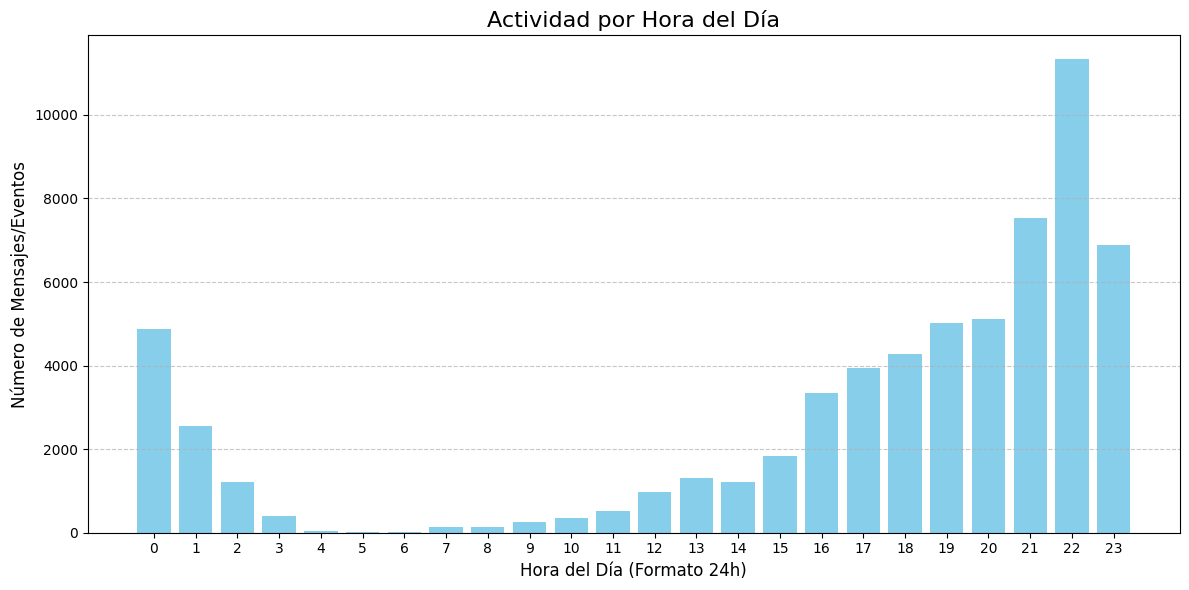


Tabla de actividad por hora del día:
hora_del_dia
0      4880
1      2555
2      1214
3       399
4        50
5        14
6        11
7       130
8       129
9       247
10      343
11      529
12      976
13     1311
14     1221
15     1845
16     3341
17     3932
18     4272
19     5027
20     5105
21     7521
22    11338
23     6875
Name: count, dtype: int64


In [ ]:
fecha_df['datetime_parseado'] = pd.to_datetime(fecha_df['datetime_parseado'], errors='coerce')

# Extraer la hora del dia
fecha_df_valid_dates = fecha_df.dropna(subset=['datetime_parseado'])
fecha_df_valid_dates['hora_del_dia'] = fecha_df_valid_dates['datetime_parseado'].dt.hour

# Contar la actividad por hora
actividad_por_hora = fecha_df_valid_dates['hora_del_dia'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(actividad_por_hora.index, actividad_por_hora.values, color='skyblue', width=0.8)

plt.title('Actividad por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día (Formato 24h)', fontsize=12)
plt.ylabel('Número de Mensajes/Eventos', fontsize=12)
plt.xticks(ticks=range(0, 24), labels=[str(h) for h in range(0, 24)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTabla de actividad por hora del día:")
print(actividad_por_hora)

Ahora comenzaremos con la creación del Modelo, pero para ello necesitaremos una base de datos extra, debido a que nuestra base de datos solo contiene conversaciones de grooming, no podriamos hacer un modelo que solo aprenda grooming y no aprenda el no grooming, por lo tanto ingresaremos la nueva base de datos

Tambien necesitamos crear un dataframe, asignandole un id a cada conversación y concatenando sus mensajes para luego etiquetarla.

In [ ]:
chats_agrupados = combined_df.groupby('file')['normalized_body'].apply(lambda msgs : ' '.join(msgs)).reset_index()
chats_agrupados.columns = ['file','full_chat']
chats_agrupados['label'] = 1
chats_agrupados.head()

file  \
0           ArmySgt1961.xml   
1            Pavlov1234.xml   
2              Socal128.xml   
3  Wulfker_Dragonslayer.xml   
4             arthinice.xml   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
from datasets import load_dataset

dataset = load_dataset("daily_dialog", trust_remote_code=True)

dataset

TypeError: BuilderConfig.__init__() got an unexpected keyword argument 'trust_remote_code'

In [ ]:
dialogos = dataset['train']

dialogos

In [ ]:
data = dialogos.to_pandas()

data

In [ ]:
data

In [ ]:
data['dialog'] = data['dialog'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))
data.head()

In [ ]:
data = data.drop(columns=['act'])
data = data.drop(columns=['emotion'])

In [ ]:
data['label'] = 0
data

In [ ]:
grooming_data = chats_agrupados.drop(columns=['file'])
grooming_data

In [ ]:
# Imprimir largo de cada chat
for i, chat in enumerate(chats_agrupados['full_chat']):
    print(f"Fila {i}: {len(chat)} caracteres")

# Obtener largo máximo y mínimo
longitudes = chats_agrupados['full_chat'].str.len()
indice_max = longitudes.idxmax()
indice_min = longitudes.idxmin()

# Mostrar resultados
print("\n🟢 Chat más largo:")
print(f"Fila {indice_max} - {longitudes[indice_max]} caracteres")

print("\n🔴 Chat más corto:")
print(f"Fila {indice_min} - {longitudes[indice_min]} caracteres")


Como tenemos un chat demasiado largo, lo eliminaremos para ver si

In [ ]:
# Imprimir largo de cada chat
for i, chat in enumerate(data['dialog']):
    print(f"Fila {i}: {len(chat)} caracteres")

# Obtener largo máximo y mínimo
longitudes = data['dialog'].str.len()
indice_max = longitudes.idxmax()
indice_min = longitudes.idxmin()

# Mostrar resultados
print("\n🟢 Chat más largo:")
print(f"Fila {indice_max} - {longitudes[indice_max]} caracteres")

print("\n🔴 Chat más corto:")
print(f"Fila {indice_min} - {longitudes[indice_min]} caracteres")

Por lo tanto hay que lograr que el dataset de data tenga aproximadamente la misma cantidad de chats con longitudes similares, para poder tener un modelo bueno, de momento usaremos este dataset, pero planeamos buscar otro que mejore lo anterior.

In [ ]:
data = data.rename(columns={'dialog': 'full_chat'})

datos_combinados = pd.concat([grooming_data, data], ignore_index=True)

datos_combinados

In [ ]:
'''from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = datos_combinados['full_chat']
y = datos_combinados['label']

vectorizer = TfidfVectorizer(max_features=10000, stop_words = 'english', sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y , test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression (max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))'''

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = datos_combinados['full_chat']
y = datos_combinados['label']

vectorizer = TfidfVectorizer(max_features=10000, stop_words = 'english', sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y , test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression (max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(figsize=(6, 5))
# Dibujamos el heatmap de la matriz de confusión
sns.heatmap(
    cm,                    # Matriz de confusión
    annot=True,                # Muestra los números dentro de cada celda
    fmt="d",                   # Formato entero
    cmap="Blues",              # Colormap azul
    xticklabels=['Not Grooming', 'Grooming'],
    yticklabels=['Not Grooming', 'Grooming']
    axes=axes
)

axes.set_title("Confusion Matrix")
axes.set_xlabel("Predicted label")
axes.set_ylabel("True label")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))